### Check Conversion

In this Notebook we will do a basic data quality check of the conversion, we will also see the immense difference in speed and data accessibility between geodatabases(standard geospatial datastructures)

The ability to subset specifically what we are looking for, and where we are looking for it without having to download a whole zip file and then open a larger vector dataset.

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import numpy as np
import random
import fiona
from shapely.geometry import box, Point
import xarray as xr

### Folk 5 classification of seabed substrates

In this case we will see if a point from the zarr dataset in a buffer of 0.1 degrees will have the same values as the same variable from the geodatabase.  We will look at Folk 5 classification of Seabed Substrate, the variable Sand (Folk_5cl == 2.0)

In [3]:
# Open geodatabase
gdb = gpd.read_file('extracted_files/EMODnet_GEO_Seabed_Substrate_All_Res/EMODnet_Seabed_Substrate_1M.gdb')

layerlist = fiona.listlayers('extracted_files/EMODnet_GEO_Seabed_Substrate_All_Res/EMODnet_Seabed_Substrate_1M.gdb')

layer = layerlist[0]
with fiona.open('extracted_files/EMODnet_GEO_Seabed_Substrate_All_Res/EMODnet_Seabed_Substrate_1M.gdb', layer=layer) as src:
    variables = src.schema['properties'].keys()
    if 'Folk_5cl_txt' in variables:
        print('Folk_5 found in variables')
        gdf = gpd.read_file('extracted_files/EMODnet_GEO_Seabed_Substrate_All_Res/EMODnet_Seabed_Substrate_1M.gdb', layer=layer, columns=['Folk_5cl', 'Folk_5cl_txt'])
        folk5clmax= gdf['Folk_5cl'].max()
        print(folk5clmax)

Folk_5 found in variables
6


### Open the zarr dataset at Folk_5cl

Find the max, how long does it take?

In [4]:
# Open zarr dataset
ds = xr.open_zarr('Seabed_substrate_1M_Sep2023.zarr')
# Choose Folk 5cl variable
var = ds['Folk_5cl']
print(np.max(var).values)

6.0


Find a random point where Folk 5cl variable is 2.0 (Sand) from the zarr dataset buffer of 0.1 degrees

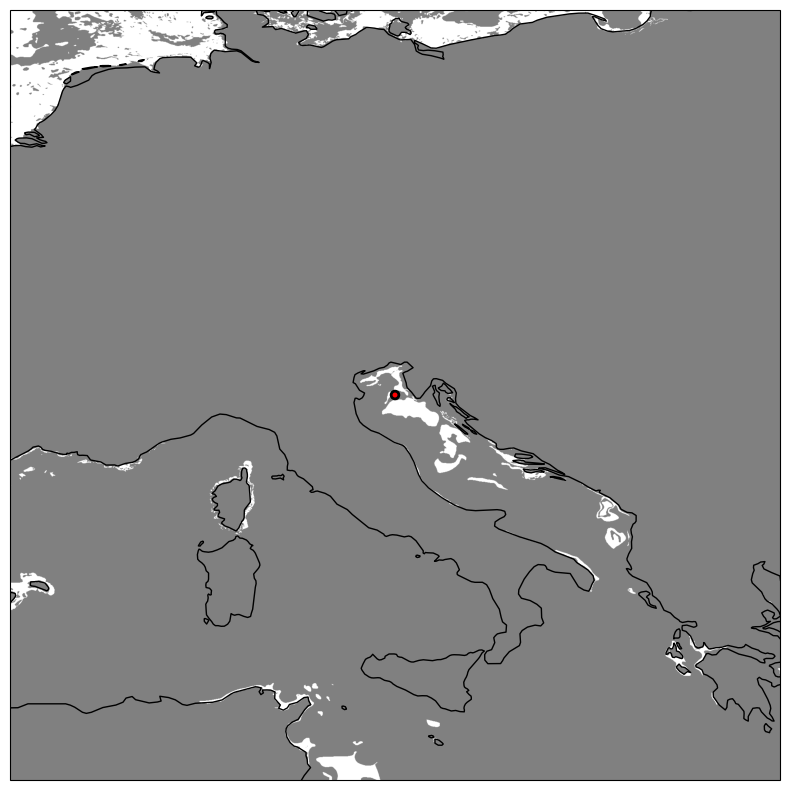

In [7]:
# Create a boolean mask where the variable is equal to 2 (Sand)
sandplot = var.values == 2.0

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()
ax.imshow(sandplot, origin='lower', transform=ccrs.PlateCarree(), cmap='gray', alpha=0.5, 
          extent=[var['longitude'].min(), var['longitude'].max(), var['latitude'].min(), var['latitude'].max()])

idx = np.where(var.values == 2.0)
lat_idx = idx[0]
lon_idx = idx[1]
# Choose a random index from the length of idx[0]
random_index = np.random.choice(len(idx[0]))
# Use the random index to get corresponding latitude and longitude
lat_start1 = var['latitude'].values[lat_idx[random_index]]
lon_start1 = var['longitude'].values[lon_idx[random_index]]


# Reduce the size of the circle if necessary
circle = Point(lon_start1, lat_start1).buffer(0.1)  # Adjust the buffer size as needed
# Add a circle to highlight the slice
circle_patch = plt.Polygon(np.array(circle.exterior.xy).T, facecolor='red', edgecolor='black', lw=2)
ax.add_patch(circle_patch)

# Zoom in to the circle
ax.set_xlim([lon_start1 - 10, lon_start1 + 10])
ax.set_ylim([lat_start1 - 10, lat_start1 + 10])

plt.show()


Plot the same circle on the geodataframe and look for the mode of values in that circle buffer

The majority of the data inside the circle is: 2


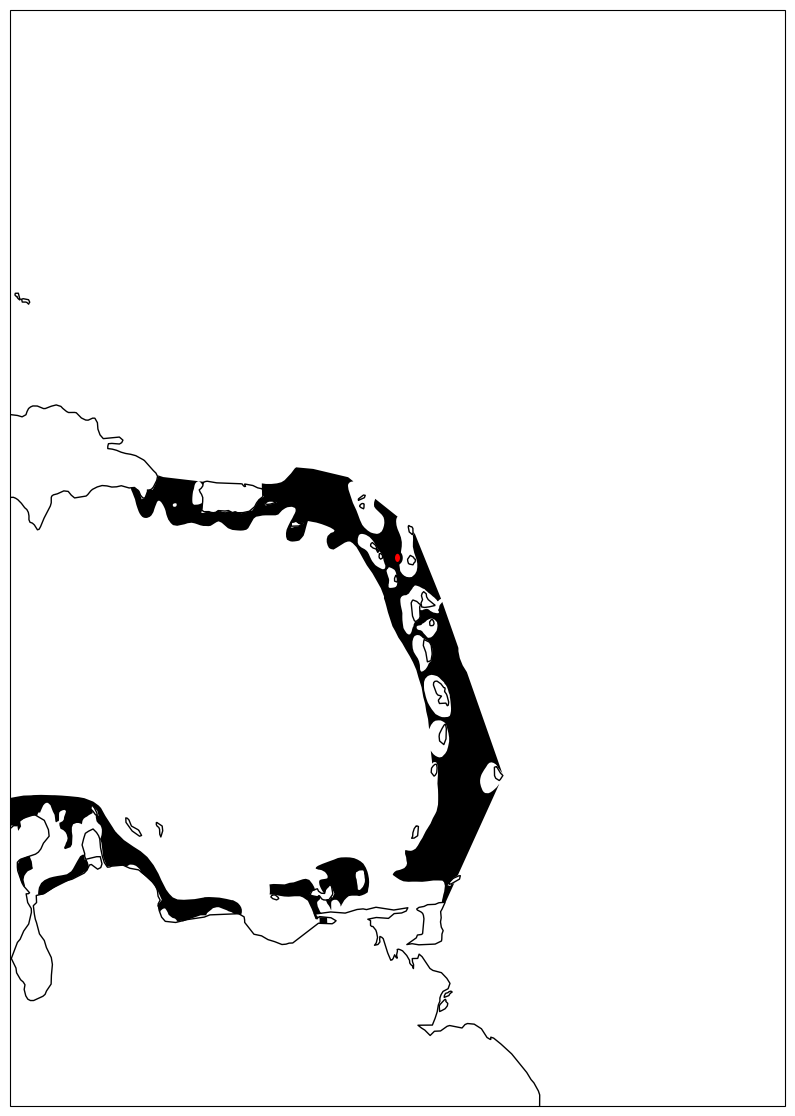

In [6]:

gdfsandplot = gdf[gdf['Folk_5cl'] == 2.0]


# Intersect the circle with the GeoDataFrame
intersect_gdf = gdf[gdf.intersects(circle)]

# Get the majority of the data inside the circle
majority_value = intersect_gdf['Folk_5cl'].mode().values[0]

print(f"The majority of the data inside the circle is: {majority_value}")

fig, ax = plt.subplots(figsize=(10, 15), subplot_kw={'projection': ccrs.PlateCarree()})
gdfsandplot.plot(ax=ax, column='Folk_5cl', cmap='grey')
ax.coastlines()

# Add a circle to highlight the slice
circle_patch = plt.Polygon(np.array(circle.exterior.xy).T, facecolor='red', edgecolor='black', lw=2)
ax.add_patch(circle_patch)

# Zoom in to the circle
ax.set_xlim([lon_start1 - 10, lon_start1 + 10])
ax.set_ylim([lat_start1 - 10, lat_start1 + 10])

plt.show()